In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

In [2]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [3]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

In [4]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([0.1]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/full_anns_diff_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


KeyboardInterrupt: 

In [9]:
''' Sensible flux models '''
Qs_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'softplus'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['hsc']
    bkeys = ['hsb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([-8]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':2e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Qs_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/full_anns_diff_sensible_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 265 epochs.
training took 56.14 seconds, loss at last epoch -25.8597
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 152 epochs.
training took 38.45 seconds, loss at last epoch -40.8033
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 242 epochs.
training took 53.95 seconds, loss at last epoch 16.7285
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 108 epochs.
training took 29.50 seconds, loss at last epoch -9.1096
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 260 epochs.
training took 68.63 seconds, loss at last epoch -14.6630
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 72 epochs.
training took 20.38 seconds, loss at last epoch 13.4080


In [10]:
''' Latent flux models '''
Ql_model_ensem = []

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    okeys = ['hlc']
    bkeys = ['hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([-90]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([50.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split

    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Ql_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/full_anns_diff_latent_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 108 epochs.
training took 22.00 seconds, loss at last epoch 6.6983
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 105 epochs.
training took 25.68 seconds, loss at last epoch 5.2179
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 105 epochs.
training took 22.56 seconds, loss at last epoch -4.1653
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 70 epochs.
training took 18.48 seconds, loss at last epoch 2.9239
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 188 epochs.
training took 48.08 seconds, loss at last epoch -4.7911
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 110 epochs.
training took 29.97 seconds, loss at last epoch 2.9483


In [7]:
''' Testing '''
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

def evaluate_over_splits (model, keys):
    nn_r2_splits = []; bulk_r2_splits = []
    for i in range(6):
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples', VERBOSE=False)
        vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
        scores = model.metrics(vd.X, vd.Y)    
        bulk_mse, bulk_r2 = mse_r2(vd.Bulk.detach().numpy(), vd.Y.detach().numpy())
        nn_r2_splits.append(scores['r2']); bulk_r2_splits.append(bulk_r2)
    return (np.array(nn_r2_splits).squeeze(), np.array(bulk_r2_splits).squeeze())
        # print('NN r2 %.4f, bulk r2 %.4f' %(scores['r2'], bulk_r2))

In [8]:
''' Momentum flux '''
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
for model in momentum_model_ensem:
    model.nn_taux_r2_splits, model.bulk_taux_r2_splits = evaluate_over_splits(model, keys)
    print(model.nn_taux_r2_splits, model.bulk_taux_r2_splits)

''' Sensible heat '''
# keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
# for model in Qs_model_ensem:
#     model.nn_hs_r2_splits, model.bulk_hs_r2_splits = evaluate_over_splits(model, keys)
#     print(model.nn_hs_r2_splits, model.bulk_hs_r2_splits)

''' Latent heat '''
# keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
# for model in Ql_model_ensem:
#     model.nn_hl_r2_splits, model.bulk_hl_r2_splits = evaluate_over_splits(model, keys)
#     print(model.nn_hl_r2_splits, model.bulk_hl_r2_splits)

[0.8494526  0.37317336 0.54589164 0.8765854  0.9254124  0.8153481 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.85246664 0.38885975 0.5374206  0.8601586  0.9150596  0.8137096 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.79364914 0.3937019  0.5229852  0.8031738  0.8971325  0.81042176] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.84091294 0.3944819  0.553399   0.82679594 0.9043787  0.8096205 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8302139  0.40633082 0.55613625 0.83621967 0.84151787 0.8142722 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8563812  0.39306378 0.5450255  0.861689   0.9154208  0.8110812 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]


' Latent heat '

[0.8494526  0.85246664 0.79364914 0.84091294 0.8302139  0.8563812 ]
[0.37317336 0.38885975 0.3937019  0.3944819  0.40633082 0.39306378]
[0.54589164 0.5374206  0.5229852  0.553399   0.55613625 0.5450255 ]
[0.8765854  0.8601586  0.8031738  0.82679594 0.83621967 0.861689  ]
[0.9254124  0.9150596  0.8971325  0.9043787  0.84151787 0.9154208 ]
[0.8153481  0.8137096  0.81042176 0.8096205  0.8142722  0.8110812 ]


Text(0.5, 1.0, 'Momentum flux $\\tau_x$')

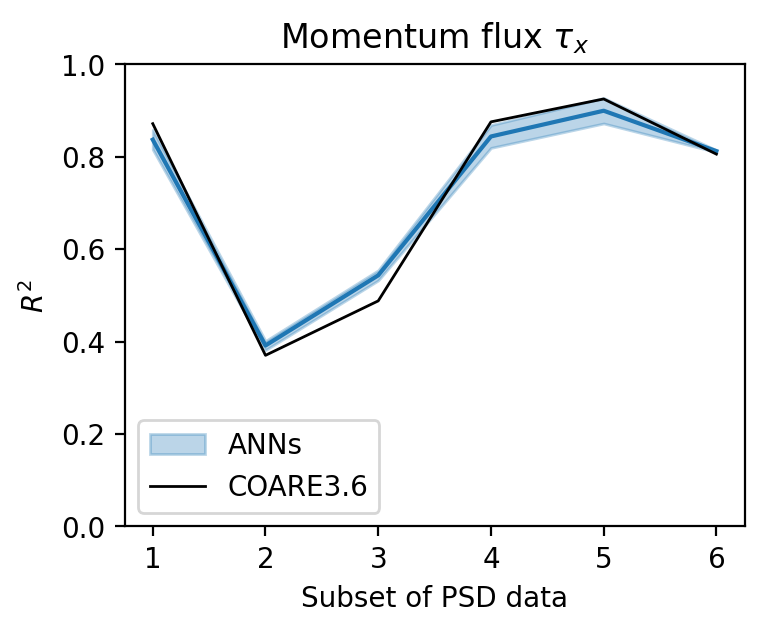

In [9]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_taux_r2_splits[i] for model in momentum_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
    # plt.plot(model.nn_r2_splits,'.-')
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, model.bulk_taux_r2_splits, '-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Momentum flux $\tau_x$')

[0.601494   0.50238955 0.63627994 0.5842022  0.6387675  0.6159314 ]
[0.01890445 0.00824773 0.02658588 0.01937038 0.02408886 0.01814532]
[0.37110198 0.34480923 0.35290796 0.35699934 0.38049352 0.34410006]
[0.79931235 0.5438945  0.68933547 0.58979785 0.7316235  0.59495044]
[0.49013042 0.46520048 0.4767155  0.47479558 0.4616276  0.47485793]
[0.84543407 0.64612126 0.7571355  0.67472124 0.78668475 0.67287624]


Text(0.5, 1.0, 'Sensible heat flux $Q_s$')

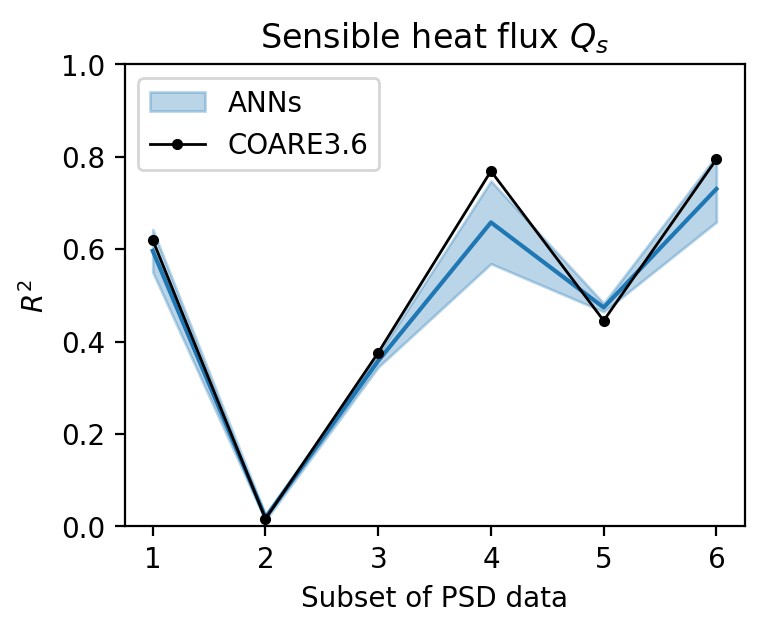

In [37]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_hs_r2_splits[i] for model in Qs_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
    # plt.plot(model.nn_r2_splits,'.-')
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, model.bulk_hs_r2_splits, '.-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Sensible heat flux $Q_s$')

[0.62539655 0.6460402  0.6867301  0.63075864 0.6713962  0.63700414]
[0.6104906  0.60677683 0.58955944 0.60141313 0.6006763  0.60420847]
[0.43367922 0.43461502 0.29327577 0.4403075  0.4216035  0.44238067]
[0.547915   0.50159174 0.6374099  0.37105656 0.5319017  0.4419858 ]
[0.40995318 0.4070689  0.38688815 0.41075957 0.38547736 0.40821642]
[0.5938963  0.56804514 0.75216293 0.44182193 0.5999674  0.48095292]


Text(0.5, 1.0, 'Latent heat flux $Q_L$')

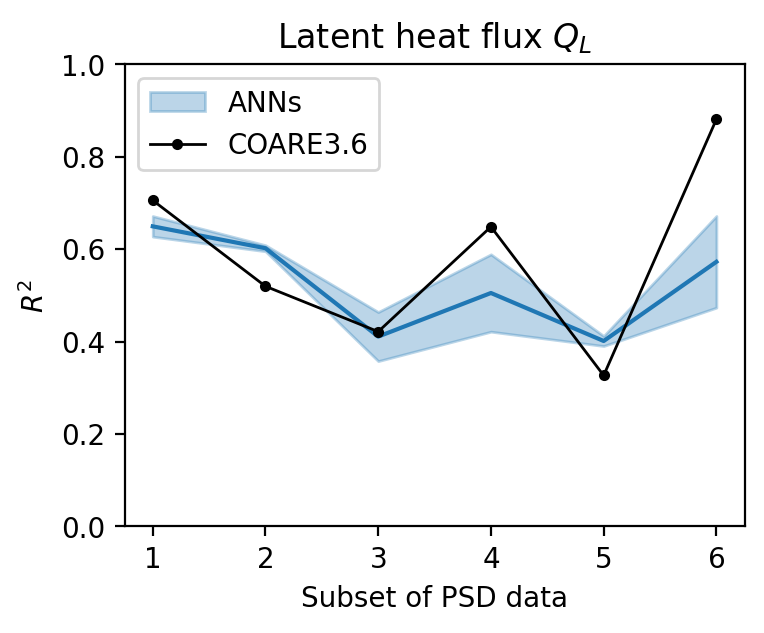

In [75]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_hl_r2_splits[i] for model in Ql_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, model.bulk_hl_r2_splits, '.-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Latent heat flux $Q_L$')

(0.0, 1.0)

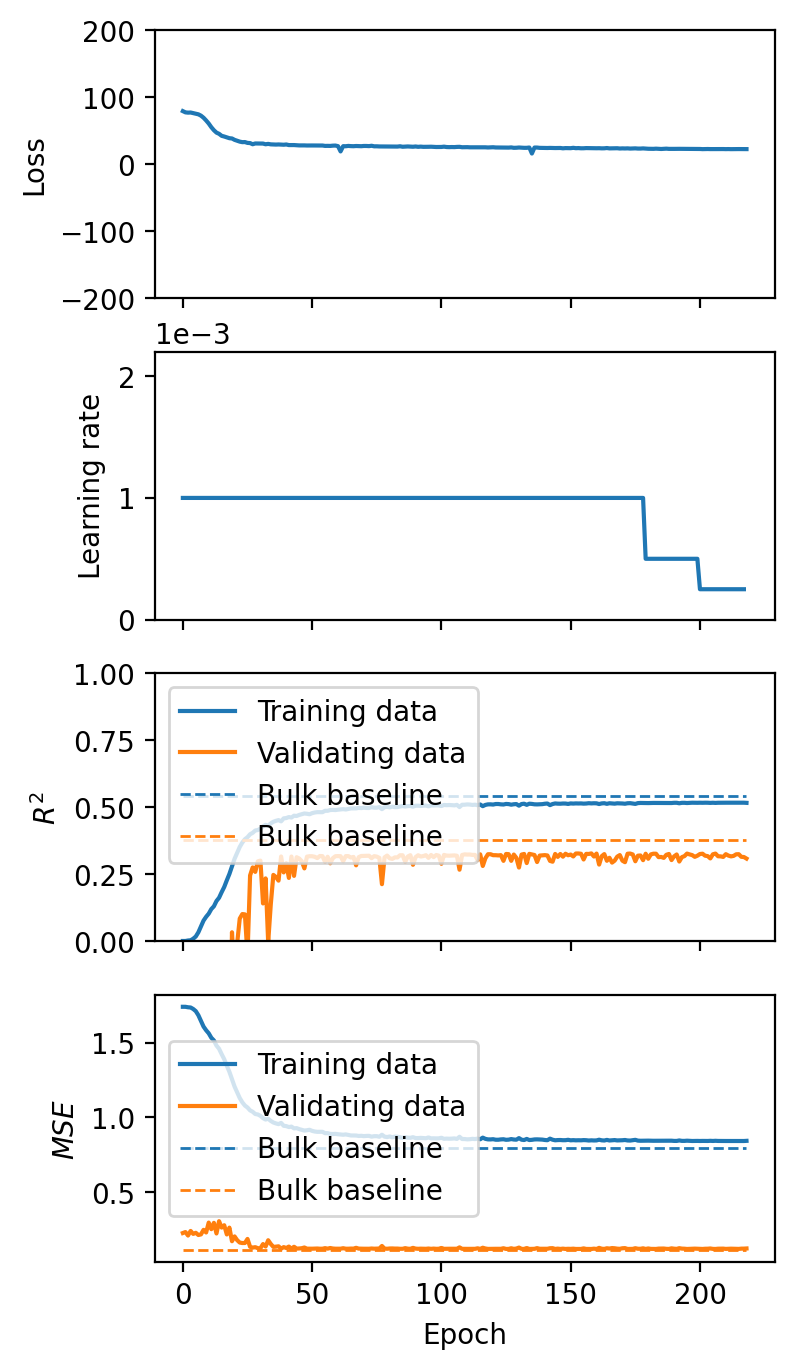

In [25]:
from mlflux.plotting import vis_training

model = Qs_model_ensem[2]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=model.datasplit, PLOT=False, XVIS='samples', VERBOSE=False)
training_data = RealFluxDataset(training_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

fig, axes = vis_training (model.log)
axes[0].set_ylim([-200,200])
axes[1].set_ylim([0,0.0022])

nepoch = len(model.log['LLLoss'])
Yscale = model.Yscale['scale'].numpy().squeeze()

bulk_mse, bulk_r2 = mse_r2(training_data.Bulk.detach().numpy(), training_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C0', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C0', label='Bulk baseline', lw=1)
bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C1', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C1', label='Bulk baseline', lw=1)
axes[2].legend()
axes[3].legend()
axes[2].set_ylim([0,1])
# axes[3].set_ylim([0,0.6])

### Plot predictions

In [28]:
def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Measurements')
    ax.plot(X,Y_pred, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='ANN Prediction (mean)')
    if LEGEND:
        ax.legend(fancybox=False)

Text(0, 0.5, 'Momentum flux $\\tau_x \\; [N/m^2]$')

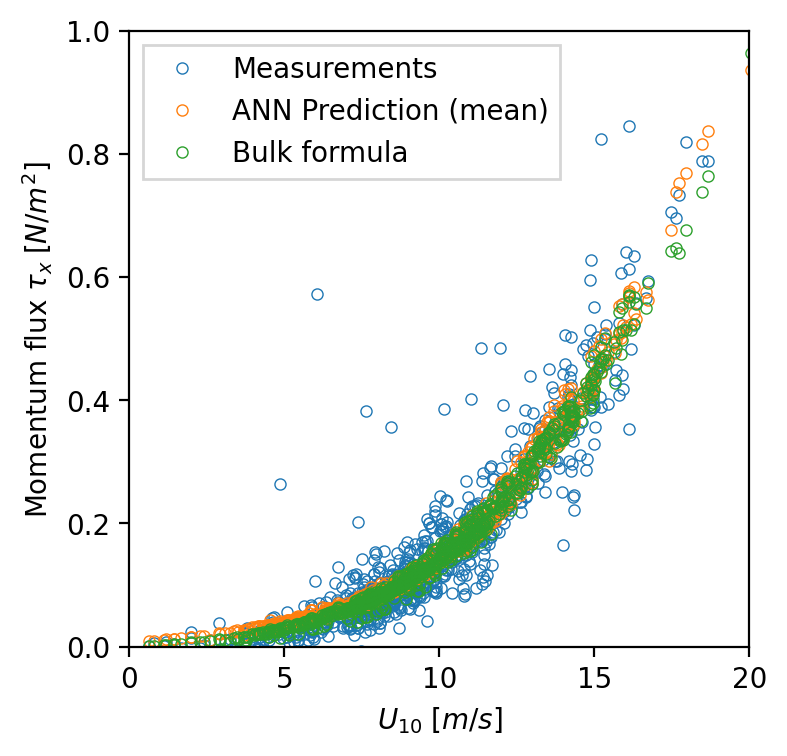

In [55]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = momentum_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,0], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,0], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([0,1]); ax.set_xlim([0,20])
ax.set_xlabel('$U_{10} \; [m/s]$'); ax.set_ylabel(r'Momentum flux $\tau_x \; [N/m^2]$')

Text(0, 0.5, 'Sensible heat flux $Q_s \\; [W/m^2]$')

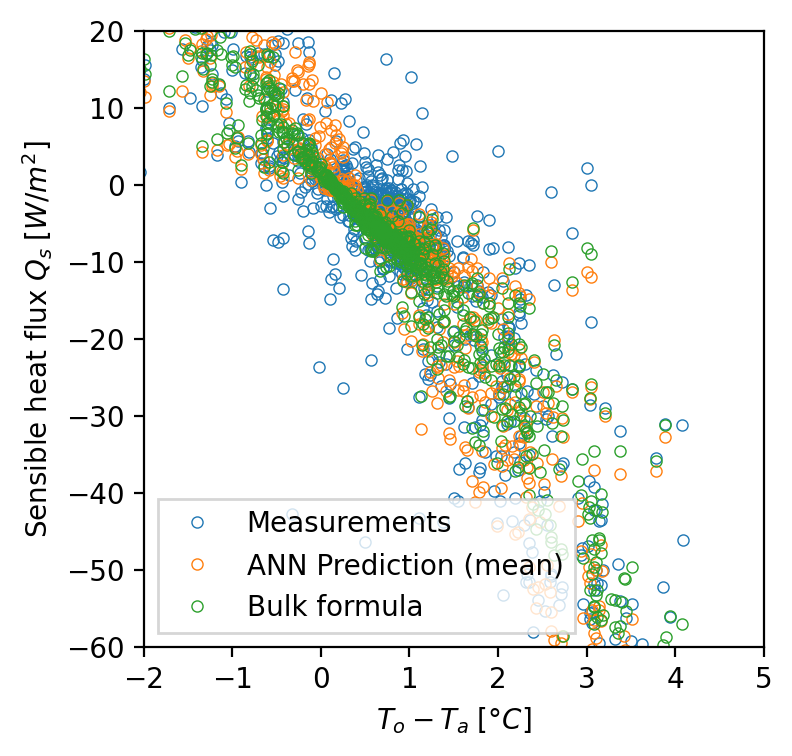

In [54]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = Qs_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-60,20]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a \; [\degree C]$'); ax.set_ylabel('Sensible heat flux $Q_s \; [W/m^2]$')

Text(0, 0.5, 'Latent heat flux $Q_L \\; [W/m^2]$')

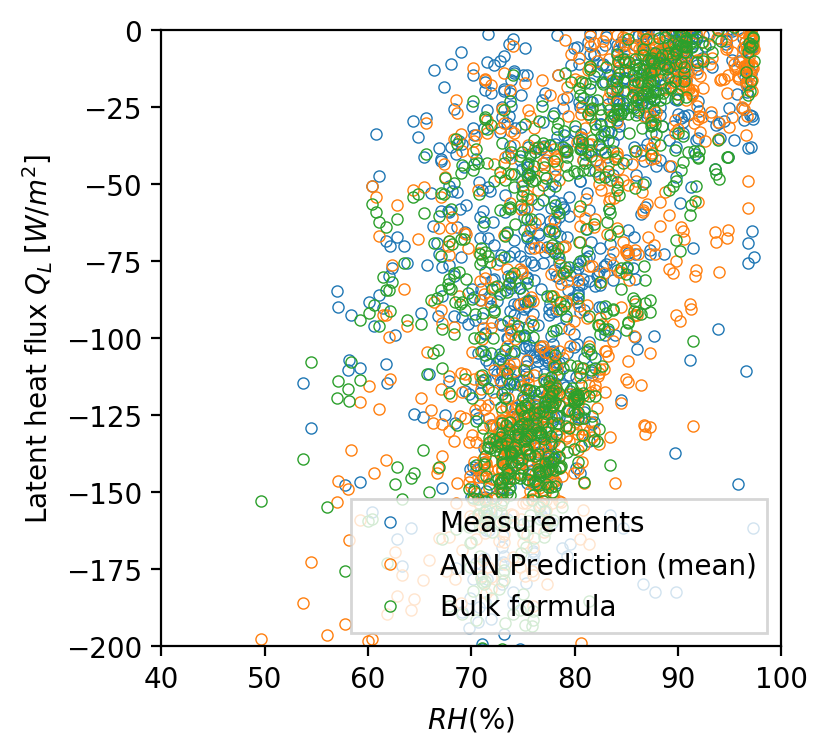

In [53]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = Ql_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,3], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,3], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-200,0]); ax.set_xlim([40,100])
ax.set_xlabel(r'$RH(\%)$')
ax.set_ylabel('Latent heat flux $Q_L \; [W/m^2]$')

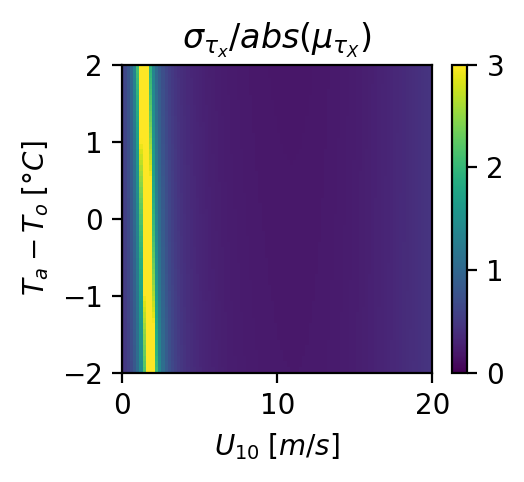

In [68]:
model = momentum_model_ensem[2]

fig = plt.figure(figsize=[2.5,2], dpi=200)
ax = plt.gca()

x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
U = np.reshape(x1_mesh,(-1,1))
tsea = (np.ones(10000)*20.).reshape(-1,1)+np.reshape(x2_mesh,(-1,1))
tair = (np.ones(10000)*20.).reshape(-1,1)
rh = (np.ones(10000)*80.).reshape(-1,1)
X_feed = torch.tensor(np.hstack([U, tsea, tair, rh]).astype('float32'))

Y_std_pred = model.pred_var(X_feed).detach().numpy().reshape(100,100)
Y_mean_pred = model.pred_mean(X_feed).detach().numpy().reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred**0.5/abs(Y_mean_pred), vmax=3., vmin=0.)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel(r'$U_{10} \; [m/s]$'); ax.set_ylabel('$T_a-T_o \; [\degree C]$')
ax.set_title(r'$\sigma_{\tau_x}/abs(\mu_{\tau_X})$')
plt.colorbar(img,ticks=[0,1,2,3])

# ax = axes[1]
# img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
# ax.set_xlim([0,20]); ax.set_ylim([-5,2])
# ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
# ax.set_title('Sample numbers')
# plt.colorbar(img[-1], ticks=[0,0.05,0.1])
# plt.show()

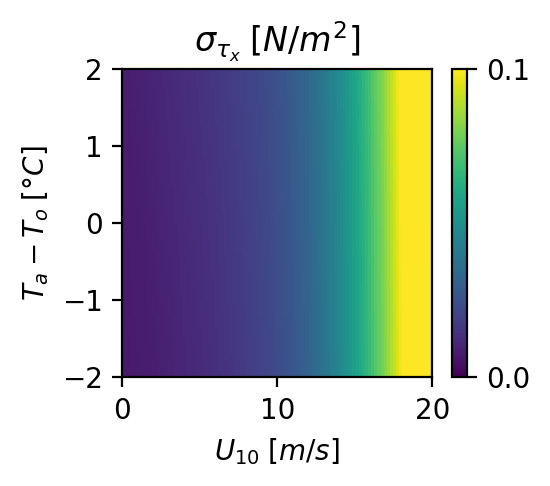

In [58]:
fig = plt.figure(figsize=[2.5,2], dpi=200)
ax = plt.gca()

x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
U = np.reshape(x1_mesh,(-1,1))
tsea = (np.ones(10000)*20.).reshape(-1,1)+np.reshape(x2_mesh,(-1,1))
tair = (np.ones(10000)*20.).reshape(-1,1)
rh = (np.ones(10000)*80.).reshape(-1,1)
X_feed = torch.tensor(np.hstack([U, tsea, tair, rh]).astype('float32'))

Y_std_pred = np.array([model.pred_var(X_feed).detach().numpy() for model in momentum_model_ensem])
Y_mean_pred = np.array([model.pred_mean(X_feed).detach().numpy() for model in momentum_model_ensem])
Y_std_pred = np.average(Y_std_pred, axis=0).reshape(100,100)
Y_mean_pred = np.average(Y_mean_pred, axis=0).reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred**0.5, vmax=0.1, vmin=0.)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel(r'$U_{10} \; [m/s]$'); ax.set_ylabel('$T_a-T_o \; [\degree C]$')
ax.set_title(r'$\sigma_{\tau_x}\; [N/m^2]$')
plt.colorbar(img,ticks=[0,0.1])


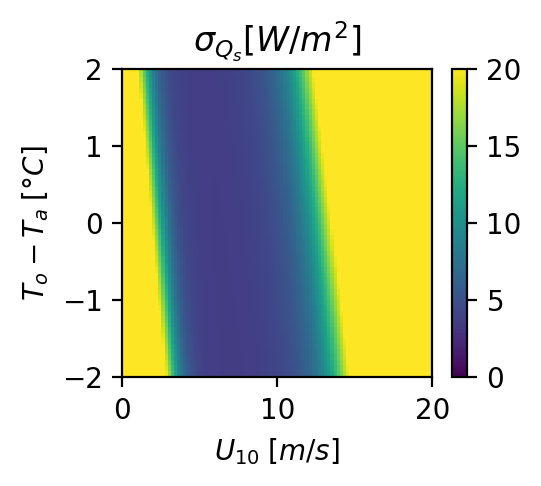

In [70]:
fig = plt.figure(figsize=[2.5,2], dpi=200)
ax = plt.gca()

x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
U = np.reshape(x1_mesh,(-1,1))
tsea = (np.ones(10000)*20.).reshape(-1,1)+np.reshape(x2_mesh,(-1,1))
tair = (np.ones(10000)*20.).reshape(-1,1)
rh = (np.ones(10000)*80.).reshape(-1,1)
X_feed = torch.tensor(np.hstack([U, tsea, tair, rh]).astype('float32'))

Y_std_pred = np.array([model.pred_var(X_feed).detach().numpy() for model in Qs_model_ensem])
Y_mean_pred = np.array([model.pred_mean(X_feed).detach().numpy() for model in Qs_model_ensem])
Y_std_pred = np.average(Y_std_pred, axis=0).reshape(100,100)
Y_mean_pred = np.average(Y_mean_pred, axis=0).reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred**0.5, vmax=20, vmin=0)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel(r'$U_{10} \; [m/s]$'); ax.set_ylabel('$T_o-T_a \; [\degree C]$')
ax.set_title(r'$\sigma_{Q_s} [W/m^2]$')
plt.colorbar(img, ticks=[0,5,10,15,20])

# ax = axes[1]
# img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
# ax.set_xlim([0,20]); ax.set_ylim([-5,2])
# ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
# ax.set_title('Sample numbers')
# plt.colorbar(img[-1], ticks=[0,0.05,0.1])
# plt.show()

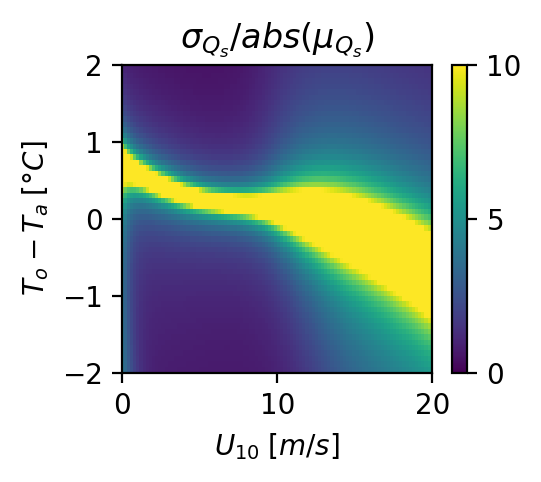

In [81]:
fig = plt.figure(figsize=[2.5,2], dpi=200)
ax = plt.gca()

x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
U = np.reshape(x1_mesh,(-1,1))
tsea = (np.ones(10000)*10.).reshape(-1,1)+np.reshape(x2_mesh,(-1,1))
tair = (np.ones(10000)*10.).reshape(-1,1)
rh = (np.ones(10000)*80.).reshape(-1,1)
X_feed = torch.tensor(np.hstack([U, tsea, tair, rh]).astype('float32'))

Y_std_pred = np.array([model.pred_var(X_feed).detach().numpy() for model in Qs_model_ensem])
Y_mean_pred = np.array([model.pred_mean(X_feed).detach().numpy() for model in Qs_model_ensem])
Y_std_pred = np.average(Y_std_pred, axis=0).reshape(100,100)
Y_mean_pred = np.average(Y_mean_pred, axis=0).reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred**0.5/abs(Y_mean_pred), vmax=10., vmin=0.)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel(r'$U_{10} \; [m/s]$'); ax.set_ylabel('$T_o-T_a \; [\degree C]$')
ax.set_title(r'$\sigma_{Q_s}/abs(\mu_{Q_s})$')
plt.colorbar(img,ticks=[0,5,10])

# ax = axes[1]
# img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
# ax.set_xlim([0,20]); ax.set_ylim([-5,2])
# ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
# ax.set_title('Sample numbers')
# plt.colorbar(img[-1], ticks=[0,0.05,0.1])
# plt.show()

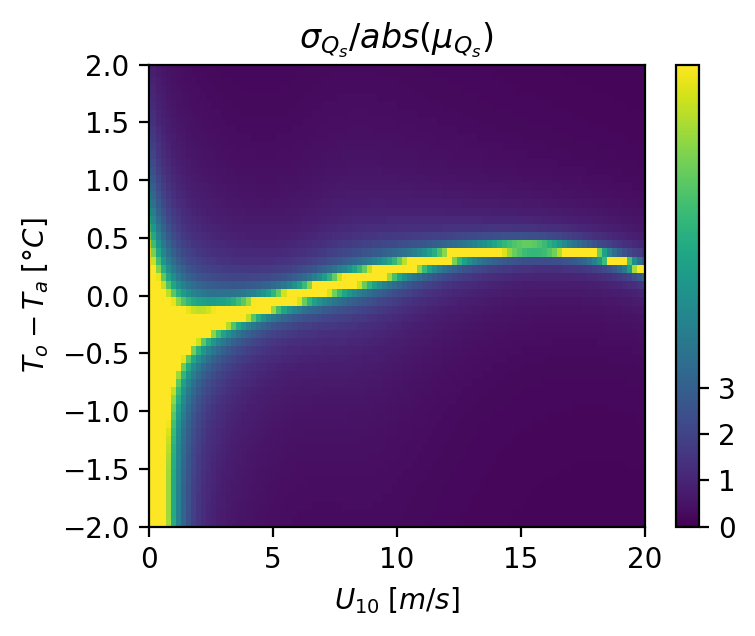

In [76]:
model = Qs_model_ensem[0]

fig = plt.figure(figsize=[4,3], dpi=200)
ax = plt.gca()

x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-5,2,100)
x1_mesh, x2_mesh = np.meshgrid(x1_vis, x2_vis)
U = np.reshape(x1_mesh,(-1,1))
tsea = (np.ones(10000)*10.).reshape(-1,1)+np.reshape(x2_mesh,(-1,1))
tair = (np.ones(10000)*10.).reshape(-1,1)
rh = (np.ones(10000)*80.).reshape(-1,1)
X_feed = torch.tensor(np.hstack([U, tsea, tair, rh]).astype('float32'))

Y_std_pred = model.pred_var(X_feed).detach().numpy().reshape(100,100)
Y_mean_pred = model.pred_mean(X_feed).detach().numpy().reshape(100,100)

img = ax.pcolormesh(x1_mesh, x2_mesh, Y_std_pred**0.5/abs(Y_mean_pred), vmax=10., vmin=0.)
ax.set_xlim([0,20]); ax.set_ylim([-2,2])
ax.set_xlabel(r'$U_{10} \; [m/s]$'); ax.set_ylabel('$T_o-T_a \; [\degree C]$')
ax.set_title(r'$\sigma_{Q_s}/abs(\mu_{Q_s})$')
plt.colorbar(img,ticks=[0,1,2,3])

# ax = axes[1]
# img = ax.hist2d(X_test[:,0], X_test[:,1], bins=40, density=True, vmax=0.1, vmin=0)
# ax.set_xlim([0,20]); ax.set_ylim([-5,2])
# ax.set_xlabel('Wind speed'); ax.set_ylabel('$T_a-T_o$')
# ax.set_title('Sample numbers')
# plt.colorbar(img[-1], ticks=[0,0.05,0.1])
# plt.show()